In [1]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2023-04-13 17:20:30.321583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 17:20:30.489750: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-13 17:20:31.005959: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victorxesus.barreiro/anaconda3/envs/deepgpu4/lib/
2023-04-13 17:20:31.005997: W tensorflow/

In [3]:
#reads a file. Each line has the format: label text
#Returns a list with the text and a list with the labels
def readData(fname):

    with open(fname, 'r', encoding="utf-8") as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    textData = list()
    textLabel = list()
    lineLength = np.zeros(len(lines))
    
    for i, aLine in enumerate(lines):     
        if not aLine:
            break  
        label = aLine.split(" ")[0]
        lineLength[i] = len(aLine.split(" "))
        if(label == "__label__1"):
            textLabel.append(0)
            textData.append(remove_prefix(aLine, "__label__1 "))

        elif(label == "__label__2"):
            textLabel.append(1)
            textData.append(remove_prefix(aLine, "__label__2 "))

        else:
            print("\nError in readData: ", i, aLine)
            exit()
    
    f.close()
    return textData, textLabel, int(np.average(lineLength)+2*np.std(lineLength))

In [4]:
from tensorflow.keras import layers

def transformData(x_train, y_train, x_test, y_test, maxFeatures, seqLength):
    #transforms text input to int input based on the vocabulary
    #max_tokens = maxFeatures is the size of the vocabulary
    #output_sequence_length =  seqLength is the maximum length of the transformed text. Adds 0 is text length is shorter
    precLayer = layers.experimental.preprocessing.TextVectorization(max_tokens = maxFeatures, 
    standardize =  'lower_and_strip_punctuation', split = 'whitespace', output_mode = 'int', 
    output_sequence_length =  seqLength)
    precLayer.adapt(x_train)
    #print(precLayer.get_vocabulary())
    x_train_int = precLayer(x_train)
    y_train = tf.convert_to_tensor(y_train)
    #print(x_train_int)
    #print(y_train)
    x_test_int= precLayer(x_test)
    y_test = tf.convert_to_tensor(y_test)
    #print(x_test_int)
    #print(y_test)

    return x_train_int, y_train, x_test_int, y_test

In [5]:
x_train, y_train, seqLength = readData("amazon/train_small.txt")
x_test, y_test, tmp = readData("amazon/test_small.txt")

#maxFeatures is a hyperparameter
maxFeatures = 10000

x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, maxFeatures, seqLength)

2023-04-13 17:20:32.232940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 17:20:32.251625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 17:20:32.251704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 17:20:32.252451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [6]:
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Input, Model
from keras.utils import plot_model

from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import time

# Directory where the checkpoints will be saved.
dir = "models/"

def visualize_fit(history):
    """Visualize the fit of a model. 

    Args:
        history (list): list of metrics along the epochs.  
    """    
    history_dict = history.history
    print(history_dict.keys())
    history_dict.keys()

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, 'b-o', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')

    plt.title('Training and validation loss: MSE')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Training and validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.ylim([0, 1])
    plt.legend()

    plt.tight_layout()
    plt.show()

def fitModel(model, ds_train, ds_val, num_epochs=20, monitor='val_mean_absolute_error', model_name='best_model.h5', callbacks=[], batch_size=32):
    """Function to train a model. It saves the best model in a file. It also prints the evolution of the training process.


    Args:
        model (Model): The model to be trained.
        ds_train (_type_): The training dataset. 
        ds_val (_type_): The validation dataset.
        num_epochs (int, optional): Defaults to 20.
        monitor (str, optional): Metric to monitor and save the best model. Defaults to 'val_mean_absolute_error'. 
        model_name (str, optional): Name of the file where the best model will be saved. Defaults to 'best_model.h5'.
        callbacks (list, optional): List of callbacks to be used during training. Defaults to [].

    Returns:
        final_metrics (list): List with the final metrics of the model
    """    
    checkpoint = ModelCheckpoint(dir + model_name, save_best_only=True, save_weights_only=False, monitor=monitor, mode='auto', verbose=1)
    history = model.fit(ds_train, verbose = 1, epochs=num_epochs, callbacks=callbacks+[checkpoint], validation_data=ds_val, batch_size=batch_size)
    result_metrics = model.evaluate(ds_val)
    print(result_metrics)
    visualize_fit(history)
    return result_metrics

In [7]:
def fitModel(model, x_train, y_train, ds_val, num_epochs=20, monitor='val_accuracy', model_name='best_model.h5', callbacks=[], batch_size=32):
    """Function to train a model. It saves the best model in a file. It also prints the evolution of the training process.


    Args:
        model (Model): The model to be trained.
        ds_train (_type_): The training dataset. 
        ds_val (_type_): The validation dataset.
        num_epochs (int, optional): Defaults to 20.
        monitor (str, optional): Metric to monitor and save the best model. Defaults to 'val_mean_absolute_error'. 
        model_name (str, optional): Name of the file where the best model will be saved. Defaults to 'best_model.h5'.
        callbacks (list, optional): List of callbacks to be used during training. Defaults to [].

    Returns:
        final_metrics (list): List with the final metrics of the model
    """    
    checkpoint = ModelCheckpoint(dir + model_name, save_best_only=True, save_weights_only=False, monitor=monitor, mode='auto', verbose=1)
    history = model.fit(x_train, y_train, verbose = 1, epochs=num_epochs, callbacks=callbacks+[checkpoint], validation_data=ds_val, batch_size=batch_size)
    visualize_fit(history)
    return history

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 1024)         10240000  
                                                                 
 lstm_1 (LSTM)               (None, 512)               3147776   
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                           

2023-04-13 17:21:28.392004: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'


98/98 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.7023
Epoch 1: val_accuracy improved from -inf to 0.64240, saving model to models/lstm.h5
98/98 [==============================] - 7s 50ms/step - loss: 0.6296 - accuracy: 0.7023 - val_loss: 0.6598 - val_accuracy: 0.6424
Epoch 2/60
97/98 [============================>.] - ETA: 0s - loss: 0.3991 - accuracy: 0.8234
Epoch 2: val_accuracy improved from 0.64240 to 0.82136, saving model to models/lstm.h5
98/98 [==============================] - 4s 39ms/step - loss: 0.3984 - accuracy: 0.8238 - val_loss: 0.5256 - val_accuracy: 0.8214
Epoch 3/60
98/98 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8849
Epoch 3: val_accuracy improved from 0.82136 to 0.82776, saving model to models/lstm.h5
98/98 [==============================] - 3s 35ms/step - loss: 0.2848 - accuracy: 0.8849 - val_loss: 0.5311 - val_accuracy: 0.8278
Epoch 4/60
98/98 [==============================] - ETA: 0s - loss: 0.2189 - accu

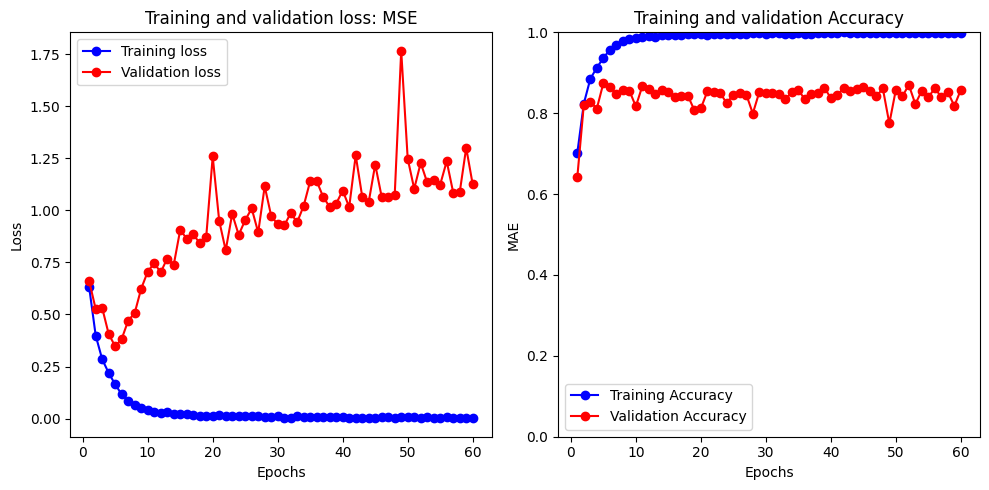

Elapsed time:  137.7491648197174


In [9]:
np.random.seed(423423)
tf.random.set_seed(1232413)
start_time = time.time()
inputs = keras.Input(shape=(seqLength, ))
x = layers.Embedding(maxFeatures, 1024, mask_zero=True)(inputs)
x = layers.LSTM(512, return_sequences=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


model.summary()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

result = fitModel(model, x_train_int, y_train, (x_test_int, y_test), num_epochs=60, model_name="lstm.h5", batch_size=256)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)  

In [10]:
model = keras.models.load_model(dir + "lstm.h5")
model.evaluate(x_test_int, y_test)

782/782 [==============================] - 3s 3ms/step - loss: 0.3469 - accuracy: 0.8740


[0.34694820642471313, 0.873960018157959]

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 166, 1024)         10240000  
                                                                 
 lstm_7 (LSTM)               (None, 512)               3147776   
                                                                 
 batch_normalization_14 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_15 (Bat  (None, 256)              1024      
 chNormalization)                                          

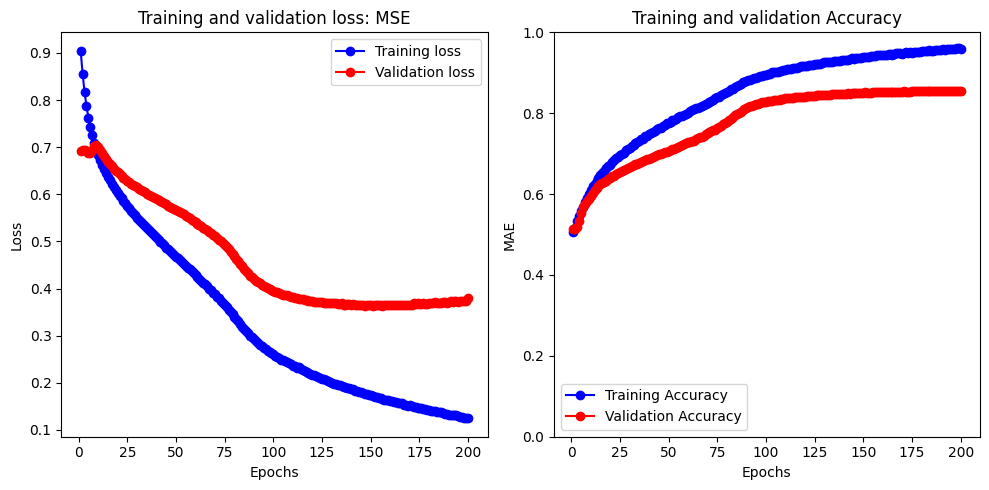

Elapsed time:  436.03433775901794


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

np.random.seed(423423)
tf.random.set_seed(1232413)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

start_time = time.time()
inputs = keras.Input(shape=(seqLength, ))
x = layers.Embedding(maxFeatures, 1024, mask_zero=True)(inputs)
x = layers.LSTM(512, return_sequences=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


model.summary()
optimizer = keras.optimizers.RMSprop(learning_rate=0.000001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

result = fitModel(model, x_train_int, y_train, (x_test_int, y_test), num_epochs=200, model_name="lstm.h5", batch_size=256, callbacks=[reduce_lr])

end_time = time.time()
print("Elapsed time: ", end_time - start_time)  

In [ ]:
model = keras.models.load_model(dir + "lstm.h5")
model.evaluate(x_test_int, y_test)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 1024)         10240000  
                                                                 
 gru (GRU)                   (None, 512)               2362368   
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                           

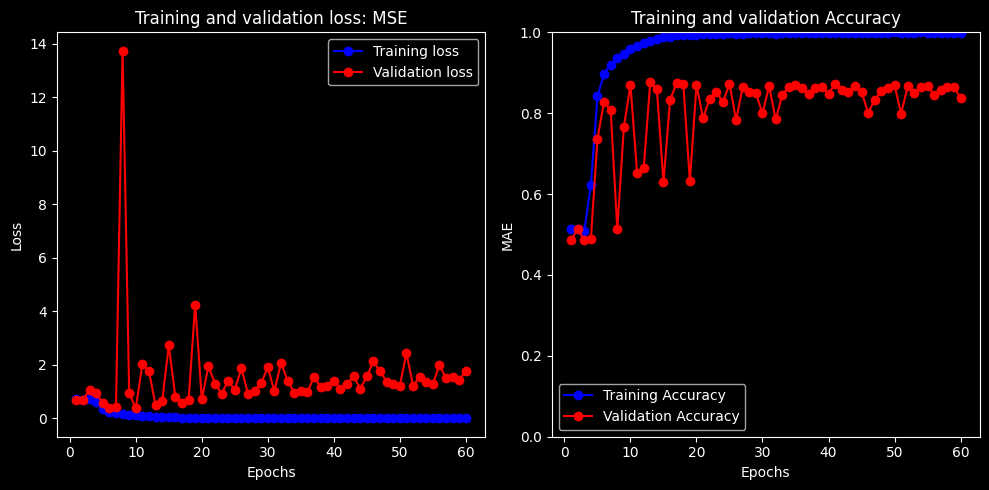

Elapsed time:  297.281174659729


In [10]:
np.random.seed(423423)
tf.random.set_seed(1232413)
start_time = time.time()
inputs = keras.Input(shape=(seqLength, ))
x = layers.Embedding(maxFeatures, 1024)(inputs)
x = layers.GRU(512, return_sequences=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


model.summary()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

result = fitModel(model, x_train_int, y_train, (x_test_int, y_test), num_epochs=60, model_name="gru.h5", batch_size=256)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)  

In [11]:
model = keras.models.load_model(dir + "gru.h5")
model.evaluate(x_test_int, y_test)

782/782 [==============================] - 6s 7ms/step - loss: 0.4857 - accuracy: 0.8776


[0.4856819212436676, 0.8776400089263916]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 166, 1024)         10240000  
                                                                 
 gru_1 (GRU)                 (None, 512)               2362368   
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                           

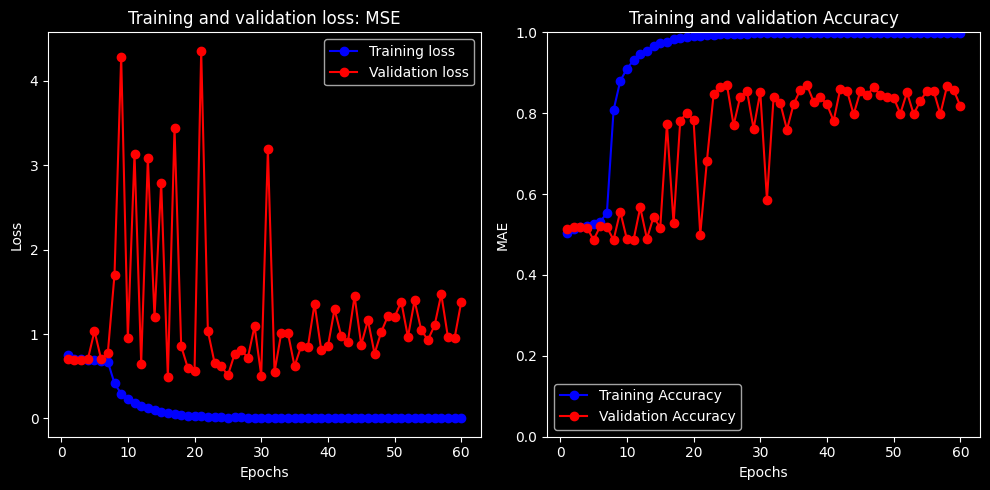

Elapsed time:  311.23730659484863


In [12]:
np.random.seed(423423)
tf.random.set_seed(1232413)
start_time = time.time()
inputs = keras.Input(shape=(seqLength, ))
x = layers.Embedding(maxFeatures, 1024)(inputs)
x = layers.GRU(512, return_sequences=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


model.summary()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

result = fitModel(model, x_train_int, y_train, (x_test_int, y_test), num_epochs=60, model_name="gru_big.h5", batch_size=256)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)  

In [13]:
model = keras.models.load_model(dir + "gru_big.h5")
model.evaluate(x_test_int, y_test)

782/782 [==============================] - 3s 3ms/step - loss: 0.5104 - accuracy: 0.8699


[0.5103753805160522, 0.869920015335083]

Comentar que al intentar introducir más capas densas los resultados empeorann.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 166, 1024)         10240000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 512)               786944    
                                                                 
 batch_normalization_7 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_8 (Batc  (None, 256)              1024      
 hNormalization)                                           

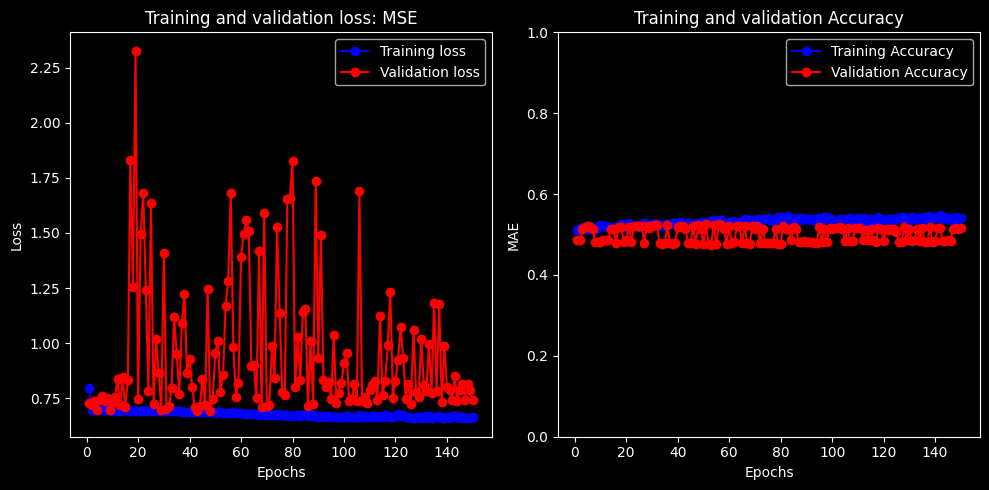

Elapsed time:  1037.1527161598206


In [14]:
np.random.seed(423423)
tf.random.set_seed(1232413)
start_time = time.time()
inputs = keras.Input(shape=(seqLength, ))
x = layers.Embedding(maxFeatures, 1024)(inputs)
x = layers.SimpleRNN(512, return_sequences=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


model.summary()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

result = fitModel(model, x_train_int, y_train, (x_test_int, y_test), num_epochs=150, model_name="simple.h5", batch_size=256)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)  

In [15]:
model = keras.models.load_model(dir + "simple.h5")
model.evaluate(x_test_int, y_test)

782/782 [==============================] - 8s 11ms/step - loss: 1.0092 - accuracy: 0.5255


[1.0092239379882812, 0.5254799723625183]

## Advanced

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 166, 128)          1280000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_10 (Bat  (None, 64)               256       
 chNormalization)                                          

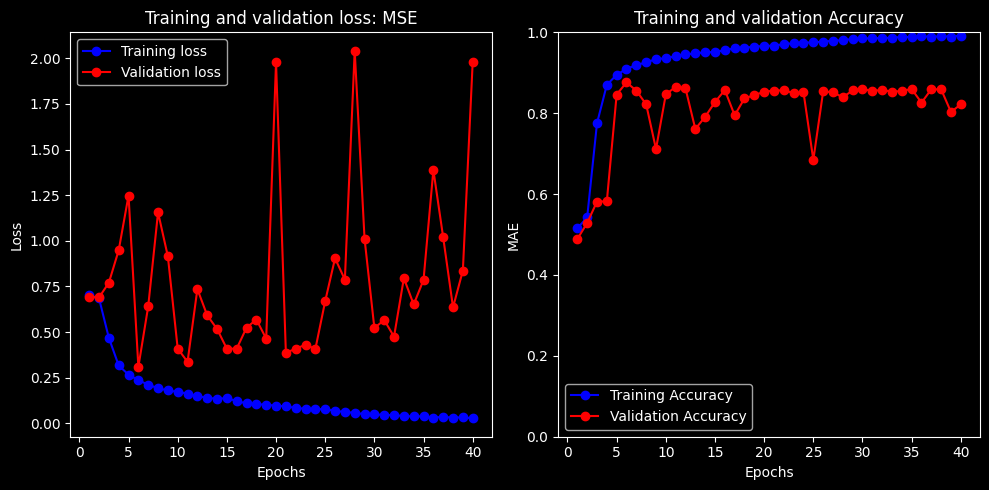

Elapsed time:  77.80317544937134


In [16]:
np.random.seed(423423)
tf.random.set_seed(1232413)
start_time = time.time()
inputs = keras.Input(shape=(seqLength, ))
x = layers.Embedding(maxFeatures, 128)(inputs)
x = layers.LSTM(64, return_sequences=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


model.summary()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

result = fitModel(model, x_train_int, y_train, (x_test_int, y_test), num_epochs=40, model_name="lstm_128.h5", batch_size=256)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)  

In [17]:
model = keras.models.load_model(dir + "lstm_128.h5")
model.evaluate(x_test_int, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 0.3095 - accuracy: 0.8762


[0.3095233738422394, 0.8762000203132629]

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 166, 1024)         10240000  
                                                                 
 gru_2 (GRU)                 (None, 512)               2362368   
                                                                 
 batch_normalization_11 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_12 (Bat  (None, 256)              1024      
 chNormalization)                                          

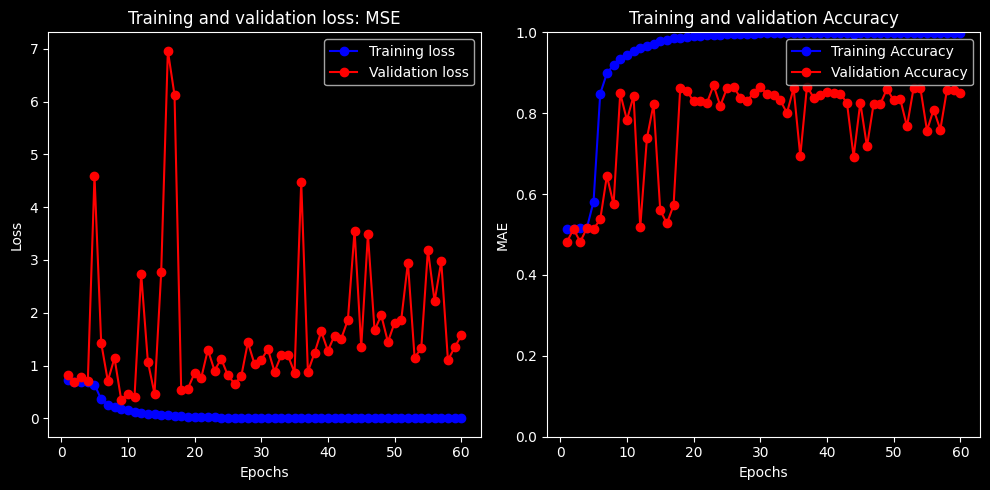

Elapsed time:  251.6163284778595


In [18]:
np.random.seed(423423)
tf.random.set_seed(1232413)
start_time = time.time()
inputs = keras.Input(shape=(seqLength, ))
x = layers.Embedding(maxFeatures, 1024)(inputs)
x = layers.GRU(512, return_sequences=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


model.summary()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

result = fitModel(model, x_train_int, y_train, (x_test_int, y_test), num_epochs=60, model_name="gru_big.h5", batch_size=256)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)  

In [19]:
model = keras.models.load_model(dir + "gru_big.h5")
model.evaluate(x_test_int, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.9079 - accuracy: 0.8692


[0.9079015851020813, 0.8691999912261963]